# ANÁLISIS DE SENTIMIENTOS PARA EVALUAR REPUTACIÓN ONLINE

(/content/sentimientos.jpg)

El análisis de sentimientos es el proceso de determinar 'computacionalmente' si un escrito es positivo, negativo o neutral. También se conoce como minería de opiniones, derivar la opinión o actitud de un hablante.

¿Por qué el análisis de sentimientos?

**Negocios**: En el campo del marketing, las empresas lo utilizan para desarrollar sus estrategias, comprender los sentimientos de los clientes hacia los productos o la marca, cómo las personas responden a sus campañas o lanzamientos de productos y por qué los consumidores no compran algunos productos.

**Política**: En el ámbito político, se utiliza para realizar un seguimiento de la visión política, para detectar consistencia e inconsistencia entre declaraciones y acciones a nivel de gobierno. ¡También se puede usar para predecir los resultados de las elecciones!

**Acciones públicas**: El análisis de sentimientos también se utiliza para monitorear y analizar los fenómenos sociales, para detectar situaciones potencialmente peligrosas y determinar el estado de ánimo general de la blogósfera.
![sentiment_analysis.jpeg](data:/content/sentimientos.jpg)


In [1]:
# Importamos librerías requeridas
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline
import os
import datetime
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Correr para saturar RAM y aplicar para expandir a 25 GB
#lista = []
#while 1:
  #lista.append('anything')

In [3]:
# Cargamos el Google Drive para almacenar los archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Update linux oS
!sudo apt update

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.7 kB]
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [2,105 kB]
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main amd64 Packages [1,079 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic

In [5]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2022-09-12 01:19:45--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2022-09-12 01:19:45--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2022-09-12 01:19:45--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:44

### Setting Up PySpark

In [6]:
# Downloading JVM
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [7]:
# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

In [8]:
# unzip the spark file to the current folder
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [9]:
# set your spark folder to your system path environment. 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [10]:
# install findspark using pip
!pip install -q findspark

In [11]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop3.2'

In [ ]:
#!pip install pyspark 
#!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

In [12]:
# entry point for spark's functionality 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
import pyspark
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, concat_ws, lit, countDistinct, desc
import pyspark.sql.functions as f

conf = SparkConf()
conf.set("spark.executor.memory", "24G")
conf.set("spark.executor.cores", "4")
conf.set("spark.driver.memory", "24G") 

conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
conf.set("spark.default.parallelism", "4")

In [13]:
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "24G").appName('SistOnReput').getOrCreate()

In [14]:
spark

### Load Dataset

In [ ]:
#tweets_sent = spark.read.csv('/content/tweets_sent_balanced', header=True, inferSchema=True)
#tweets_sent = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/SISTEMA REPUTACION ONLINE/tweets_sent_balanced', header=True, inferSchema=True )
#tweets_sent = spark.read.csv('/content/df_tweets_prueba.csv', header=True, inferSchema=True)

In [15]:
#tweets_bnpl = pd.read_excel('/content/bnpl_excel.xlsx')

In [16]:
#tweets_bnpl.head()

# Bar chart showing the amount of tweets by Sentiment
sns.countplot(x='SENTIMIENTO',data=tweets_bnpl)
plt.title('Distribución de Noticias según sentimiento (Positivo - Negativo - Neutral)', loc='center', pad='20', fontsize='14')
plt.xlabel('Tipo de Sentimiento')
plt.ylabel('Cantidad de Noticias')
plt.show()
format = tweets_bnpl.SENTIMIENTO.value_counts()
print(f"Hay {format[0]} noticias catalogados como NEGATIVAS, {format[1]} noticias catalogados como POSITIVAS") #{format[2]} noticias catalogados como NEUTRALES

# declaring data
data = [19, 4]
keys = ['Neutrales', 'Positivos']
  
# declaring exploding pie
explode = [0, 0.1]
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')
  
# displaying chart
plt.show()

In [ ]:
#tweets_bnpl= spark.read.csv('/content/bnpl.csv', header=True, inferSchema=True)

In [ ]:
#tweets_bnpl_pd.to_excel('bnpl_excel.xlsx', index=False)

In [ ]:
#tweets_bnpl = tweets_bnpl.filter("tweet_id IS NOT NULL and tweet_text IS NOT NULL and sentiment IS NOT NULL OR tweet_text IS NOT NULL")

In [ ]:
#tweets_sent = tweets_sent.filter("tweet_id IS NOT NULL and tweet_text IS NOT NULL and sentiment IS NOT NULL OR tweet_text IS NOT NULL")
#tweets_sent = tweets_sent.filter("sentiment == 'POSITIVE' OR sentiment == 'NEGATIVE' OR sentiment == 'NEUTRAL'")


In [ ]:
#tweets_sent_df = tweets_sent.toPandas()

In [ ]:
#tweets_sent_df.sentiment.value_counts()

NEUTRAL     7806
POSITIVE    7804
NEGATIVE    7788
Name: sentiment, dtype: int64

### Balancing the Dataset

In [ ]:
#tweets_sent_df = tweets_sent_df

In [ ]:
#count_neut, count_pos, count_neg = tweets_sent_df.sentiment.value_counts()

In [ ]:
#df_neut = tweets_sent_df[tweets_sent_df['sentiment']=='NEUTRAL']
#df_pos = tweets_sent_df[tweets_sent_df['sentiment']=='POSITIVE']
#df_negt = tweets_sent_df[tweets_sent_df['sentiment']=='NEGATIVE']

In [ ]:
#df_neut_under = df_neut.sample(count_neg)
#df_pos_under = df_pos.sample(count_neg)

In [ ]:
#tweets_sent_balanced = pd.concat([df_neut_under,df_pos_under,df_negt], axis=0)


In [ ]:
#tweets_sent_balanced.sentiment.value_counts()

tweets_sent_df = tweets_sent.toPandas()

sns.countplot(x='sentiment',data=tweets_sent_df)
plt.title('Distribución de tweets según sentimiento (Positivo - Negativo - Neutral)', loc='center', pad='20', fontsize='14')
plt.xlabel('Tipo de Sentimiento')
plt.ylabel('Cantidad de Tweets')
plt.show()
format = tweets_sent_df.sentiment.value_counts()
print(f"Hay {format[0]} tweets catalogados como NEUTRAL, {format[1]} tweets catalogados como POSITIVE, {format[2]} tweets catalogados como NEGATIVE")

In [ ]:
#df_tweets = tweets_sent_df[['tweet_text', 'sentiment']]

In [ ]:
#df_tweets.head()

,tweet_text,sentiment
0,"Si salimos vivos entre septiembre y octubre, e...",NEUTRAL
1,"? Hoy es el cumplea�os de @stevemacca11, scous...",NEUTRAL
2,En Vivo | �Final del partido! #ManchesterCity ...,NEUTRAL
3,#ManchesterUnited derrot� por 2-1 a #Watford. ...,NEUTRAL
4,Visto #Wolverhampton vs #Everton (2-2). Me esp...,NEUTRAL


In [ ]:
#df_tweets['text'] = df_tweets['tweet_text']

In [ ]:
#df_tweets = df_tweets.drop('tweet_text', axis=1)

In [ ]:
#df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23398 entries, 0 to 23397
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  23398 non-null  object
 1   text       23398 non-null  object
dtypes: object(2)
memory usage: 365.7+ KB


In [ ]:
#tweets_full = pd.read_csv(r'/content/tweets_sent_balanced')


#df = pd.read_csv("data.txt", sep="\t", header=None, names=["A", "B"])

In [ ]:
#tweets_full.sentiment.value_counts()

NEUTRAL     7828
POSITIVE    7828
NEGATIVE    7828
Name: sentiment, dtype: int64

In [ ]:
#tweets_full.head()

,tweet_date_created,tweet_id,tweet_text,language,sentiment,sentiment_score
0,2018-08-30T21:13:48.162000,1035274412113756162,"Si salimos vivos entre septiembre y octubre, e...",es,NEUTRAL,"""{""""Neutral"""":0.698924005031585693359375"
1,2018-08-20T08:30:25.584000,1031458419390275584,"? Hoy es el cumplea�os de @stevemacca11, scous...",es,NEUTRAL,"""{""""Neutral"""":0.92725276947021484375"
2,2018-08-05T16:04:18.969000,1026136824060755969,En Vivo | �Final del partido! #ManchesterCity ...,es,NEUTRAL,"""{""""Neutral"""":0.929748952388763427734375"
3,2018-09-15T19:37:02.888000,1041048262952869888,#ManchesterUnited derrot� por 2-1 a #Watford. ...,es,NEUTRAL,"""{""""Neutral"""":0.98564732074737548828125"
4,2018-08-12T12:05:27.008000,1028613433212715008,Visto #Wolverhampton vs #Everton (2-2). Me esp...,es,NEUTRAL,"""{""""Neutral"""":0.834743082523345947265625"


In [17]:
robert_pred = pd.read_csv(r'/content/predictions_roberta.csv')

In [18]:
robert_pred.sentimiento.value_counts()

Negative    8718
Positive    8564
Neutral     6108
Name: sentimiento, dtype: int64

In [19]:
robert_pred.head()

,Unnamed: 0,Unnamed: 0.1,sentiment,text,tweets_transform,text.1,resultado pred,sentimiento,prediction
0,0,0,NEUTRAL,"Si salimos vivos entre septiembre y octubre, e...",Si salimos vivos septiembre octubre Liverpool...,"Si salimos vivos entre septiembre y octubre, e...",2,Positive,POSITIVE
1,1,1,NEUTRAL,"? Hoy es el cumplea�os de @stevemacca11, scous...",Hoy cumplea scouser marc 50 goles camiseta R...,"? Hoy es el cumplea�os de @stevemacca11, scous...",2,Positive,POSITIVE
2,2,2,NEUTRAL,En Vivo | �Final del partido! #ManchesterCity ...,Vivo Final partido ManchesterCity venci 20 Che...,En Vivo | �Final del partido! #ManchesterCity ...,1,Neutral,NEUTRAL
3,3,3,NEUTRAL,#ManchesterUnited derrot� por 2-1 a #Watford. ...,ManchesterUnited derrot 21 Watford Alexis S n...,#ManchesterUnited derrot� por 2-1 a #Watford. ...,1,Neutral,NEUTRAL
4,4,4,NEUTRAL,Visto #Wolverhampton vs #Everton (2-2). Me esp...,Visto Wolverhampton vs Everton 22 esperaba ...,Visto #Wolverhampton vs #Everton (2-2). Me esp...,2,Positive,POSITIVE


In [20]:
robert_pred.sentiment.value_counts()

NEUTRAL     7804
POSITIVE    7804
NEGATIVE    7782
Name: sentiment, dtype: int64

In [21]:
# Eliminamos duplicados
robert_pred.drop_duplicates(subset='text', inplace=True)
print('Número de duplicados:', robert_pred['text'].duplicated().sum())

Número de duplicados: 0


Text(0.5, 1.0, 'Número de tweets por etiqueta')

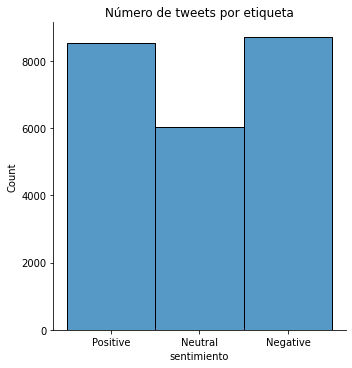

In [22]:
sns.displot(robert_pred.sentimiento);
plt.title('Número de tweets por etiqueta')

In [23]:
df = robert_pred[robert_pred.sentiment != 'NEUTRAL']

In [24]:
df.sentiment.value_counts()

POSITIVE    7787
NEGATIVE    7774
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Número de tweets por etiqueta')

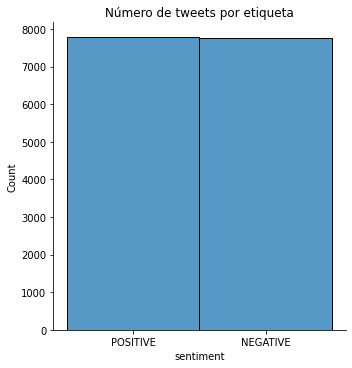

In [25]:
sns.displot(df.sentiment);
plt.title('Número de tweets por etiqueta')

### Análisis Exploratorio y Preparación de los Datos

In [26]:
# Función para stemizar
from nltk.stem.snowball import SnowballStemmer

def stem(df):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in df.split()])

In [27]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 13.7 MB/s 


In [28]:
# Función para corregir las palabras

from spellchecker import SpellChecker

spell = SpellChecker(language='es', distance=1)

def correcting_words(df):
    misspelled = spell.unknown(df.split())
    return " ".join([spell.correction(word) if word in misspelled else word for word in df.split()])

In [29]:
!python -m spacy download es_core_news_md

2022-09-12 01:34:26.702841: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [30]:
# Función para lematizar

# Creamos el objeto
import spacy
import es_core_news_md
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = es_core_news_md.load()

# Definimos función
def lemmatizer(df):
    word_list = []
    doc = nlp(df)
    for tok in doc:
        if str(tok) == 'menc':
              word_list.append('{menc}')
        elif str(tok) == 'hash':
              word_list.append('{hash}')
        elif str(tok) == 'link':
              word_list.append('{link}')
        elif str(tok) == 'emoji_pos':
              word_list.append('{emoji_pos}')
        elif str(tok) == 'emoji_neu':
              word_list.append('{emoji_neu}')
        elif str(tok) == 'emoji_neg':
              word_list.append('{emoji_neg}')
        elif str(tok) == 'eur':
              word_list.append('{eur}')
        else:
            word_list.append(tok.lemma_.lower())

    return " ".join([word for word in word_list if (word != '{') and (word!='}')]) 

In [31]:
# Creamos la funcion 'transform_text' que va a remover stopwords y algunos caracteres peculiares de twitter


def transform_text(text):
  stopWords = set(stopwords.words('spanish'))
  text = str(text)
  text = re.sub(r'@[A-Za-z0-9]+', ' ', text) #Remover menciones @
  text = re.sub(r'RT[|\s]', ' ', text) # Remover RTs
  text = re.sub(r'#', ' ', text) #Remover # en el tweet
  text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
  text = text.lstrip(' ') # Remover espacios delante del texto
  #text = correcting_words(text)

  pattern = r'''(?x)                    # set flag to allow verbose regexps
              (?:[A-Z]\.)+            # abbreviations, e.g. U.S.A
              | \w+(?:-\w+)*          # Words with optional internal hyphens
              | \$?\d+(?:\.\d+)?%?    # Currency and precentages, e.g. $12.40 82%
              | \.\.\.                # Ellipsis
              | [][.,;"'?():-_`]      #These are separate tokens; includes ],[
              '''
  words = nltk.regexp_tokenize(text, pattern)
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # Remover signos de puntuacion
  stripped = [re_punc.sub('', w) for w in words]
  no_garbage = [w for w in stripped if  w.lower() not in stopWords] # Remover stopwords
  result = [lemmatizer(w) for w in no_garbage]

  return (" ".join(result))

In [32]:
df.text = df.text.apply(transform_text)

In [33]:
df.head()

,Unnamed: 0,Unnamed: 0.1,sentiment,text,tweets_transform,text.1,resultado pred,sentimiento,prediction
7804,7806,7806,POSITIVE,gran noticia poder respirar tranquilo premierl...,Gran noticia puede respirar tranquilo PremierL...,�Gran noticia y el @SpursOfficial ya puede res...,2,Positive,POSITIVE
7805,7807,7807,POSITIVE,buen hincha chelseafc opinar,buen hincha Chelseafc opinas,@DeportesKC como un buen hincha del #Chelseafc...,1,Neutral,NEUTRAL
7806,7808,7808,POSITIVE,bien ahora seguir as contar todo confianza raf...,bien ahora seguir as cuenta toda confianza Raf...,Que bien lo de @salorondon23 ahora a seguir as...,2,Positive,POSITIVE
7807,7809,7809,POSITIVE,retirar él cole poder ver enserio precio cryliv,Retirarse cole poder ver enserio precio CRYLIV,Retirarse del cole para poder ver a @LFC enser...,0,Negative,NEGATIVE
7808,7810,7810,POSITIVE,ruguayo tas loco merecer pibe tremendo jugador,ruguayo Tas loco merece pibe tremendo jugador,@Buysan @LTorreira34 @Arsenal @U_ru_guayo Tas ...,2,Positive,POSITIVE


In [34]:
# Creamos X,y

X = df['text']
y = df.replace({'sentiment': {'NEGATIVE': 0, 'POSITIVE': 1}})['sentiment']

In [35]:
# Creamos train/test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.2)

In [36]:
# Vectorizamos
from sklearn.feature_extraction.text import CountVectorizer

# Creamos objeto y entrenamos
baseline_vectorizer = CountVectorizer(binary = True,
                                      ngram_range=(1, 3))
baseline_vectorizer.fit(X_train)

# Transformamos X en sparse vector
X_train_baseline = baseline_vectorizer.transform(X_train)
X_test_baseline = baseline_vectorizer.transform(X_test)

### Logistic Regression Modelo (Count-Vectorized)

In [37]:
%%time
from sklearn.linear_model import LogisticRegression

# Creamos modelo
lr_cv_params = dict(C = [0.25, 0.5, 0.75],
                    penalty = ['l1', 'l2'],
                    class_weight = [None, 'balanced'],
                    solver = ['newton-cg', 'sag', 'lbfgs'])

lr_cv_grid = GridSearchCV(LogisticRegression(max_iter = 300),
                     lr_cv_params,
                     cv = 5,
                     n_jobs = -1,
                     scoring = 'accuracy').fit(X_train_baseline,
                                               y_train)
print('Best score:', lr_cv_grid.best_score_)
print('Best params:', lr_cv_grid.best_params_)

Best score: 0.8634323876462056
Best params: {'C': 0.75, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'}
CPU times: user 2.32 s, sys: 202 ms, total: 2.52 s
Wall time: 35.9 s


In [38]:
y_pred_log_reg_cv_proba = lr_cv_grid.predict_proba(X_test_baseline)
y_pred_log_reg_cv_proba

array([[0.27815168, 0.72184832],
       [0.99217373, 0.00782627],
       [0.15585907, 0.84414093],
       ...,
       [0.74276303, 0.25723697],
       [0.47250298, 0.52749702],
       [0.0365099 , 0.9634901 ]])

#### TF-IDF

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Vectorizamos
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#### Logistic Reg 2

In [40]:
# Entrenamos reg. log
from sklearn.linear_model import LogisticRegression

lr_tfidf_params = dict(
    C = [0.5, 1, 1.5, 2]
)
lr_tfidf = GridSearchCV(LogisticRegression(),
                        lr_tfidf_params,
                        cv = 5,
                        scoring = 'accuracy',
                        n_jobs = -1).fit(X_train_tfidf, y_train)

print('Best score:', lr_tfidf.best_score_)
print('Best params:', lr_tfidf.best_params_)

Best score: 0.8658425425284907
Best params: {'C': 2}


### Predicting with LR model

In [41]:
# Función para establecer el threshold en 0.5
def get_label_predict(probas):
  if np.argmax(probas)<= 0.5:
    return 0
  else:
    return 1

In [42]:
# Función para predecir
def pred_tweet(text):
  text = transform_text(text)
  sentiment = ['Negativo', 'Positivo']
  X_pred = baseline_vectorizer.transform([text])
  #print(lr_cv_grid.predict_proba(X_pred))
  #print('Tweet sentiment:', sentiment[get_label_predict(lr_cv_grid.predict_proba(X_pred)[0])])
  result = sentiment[get_label_predict(lr_cv_grid.predict_proba(X_pred)[0])]
  return result

In [43]:
pred_tweet("""Que el 90% de los mensajes que se están dando de cara \
a las navidades están hechos pensando en familias nucleares estándar es algo que me fascina.
El no te juntes con nadie puede ser un poquito duro si vives solo, por ejemplo, y no es precisamente el caso de poca gente.""")

'Negativo'

In [44]:
pred_tweet('¡Enhorabuena! Trabajazo de @susanasolisp como \
negociadora del @Europarl_ES de los fondos estructurales. \
Explicación en el hilo.')

'Positivo'

In [45]:
df.head()

,Unnamed: 0,Unnamed: 0.1,sentiment,text,tweets_transform,text.1,resultado pred,sentimiento,prediction
7804,7806,7806,POSITIVE,gran noticia poder respirar tranquilo premierl...,Gran noticia puede respirar tranquilo PremierL...,�Gran noticia y el @SpursOfficial ya puede res...,2,Positive,POSITIVE
7805,7807,7807,POSITIVE,buen hincha chelseafc opinar,buen hincha Chelseafc opinas,@DeportesKC como un buen hincha del #Chelseafc...,1,Neutral,NEUTRAL
7806,7808,7808,POSITIVE,bien ahora seguir as contar todo confianza raf...,bien ahora seguir as cuenta toda confianza Raf...,Que bien lo de @salorondon23 ahora a seguir as...,2,Positive,POSITIVE
7807,7809,7809,POSITIVE,retirar él cole poder ver enserio precio cryliv,Retirarse cole poder ver enserio precio CRYLIV,Retirarse del cole para poder ver a @LFC enser...,0,Negative,NEGATIVE
7808,7810,7810,POSITIVE,ruguayo tas loco merecer pibe tremendo jugador,ruguayo Tas loco merece pibe tremendo jugador,@Buysan @LTorreira34 @Arsenal @U_ru_guayo Tas ...,2,Positive,POSITIVE


In [46]:
lista_palabras = df['tweets_transform'].to_list()

In [47]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

stoplist = set(stopwords.words('spanish'))

def word_cloud(wd_list):
    #stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stoplist,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

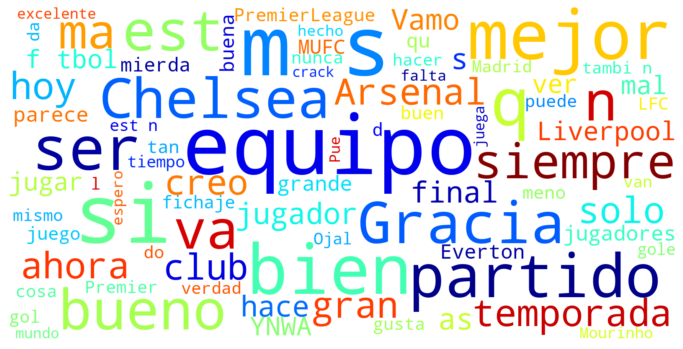

In [48]:
 word_cloud(lista_palabras)

In [49]:
df = df[['text', 'sentiment']]

In [50]:
df['text1'] = df['text'].apply(transform_text)

In [51]:
df = df.drop('text', axis=1)

In [52]:
df.rename(columns = {'text1':'text'}, inplace = True)

In [53]:
df.head()

,sentiment,text
7804,POSITIVE,gran noticia poder respirar tranquilo premierl...
7805,POSITIVE,buen hincha chelseafc opinar
7806,POSITIVE,bien ahora seguir as contar confianza rafa ben...
7807,POSITIVE,retirar cole poder ver enserio precio cryliv
7808,POSITIVE,ruguayo tos loco merecer pibe tremendo jugador


In [ ]:
#df_tweets.to_csv('df_tweets_prueba.csv')

In [54]:
# df_spark = spark.createDataFrame(data)

#df_tweets_sp = spark.createDataFrame(df_tweets)
#df_tweets_sp = df_tweets_sp.drop('text')

#tweets_bnpl = tweets_bnpl[['tweets_transform']]
df_tweets_spark = spark.createDataFrame(df)

In [55]:
#df_tweets_sp = df_tweets_sp.withColumnRenamed('tweets_transform', 'text')

In [56]:
df_tweets_spark.show()

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
| POSITIVE|gran noticia pode...|
| POSITIVE|buen hincha chels...|
| POSITIVE|bien ahora seguir...|
| POSITIVE|retirar cole pode...|
| POSITIVE|ruguayo tos loco ...|
| POSITIVE|mou descans jugad...|
| POSITIVE|     suerte positivo|
| POSITIVE|fin ir tener port...|
| POSITIVE|restrar mejor equ...|
| POSITIVE|madre m qu hijuep...|
| POSITIVE|delantero favorit...|
| POSITIVE|premierleaguir so...|
| POSITIVE|mano echalir bola...|
| POSITIVE|ir segundo partid...|
| POSITIVE|incre ble partido...|
| POSITIVE|si equipo poder p...|
| POSITIVE|superar penal ami...|
| POSITIVE|enhorabuena aqu d...|
| POSITIVE|definitivamente s...|
| POSITIVE|gustado verte jug...|
+---------+--------------------+
only showing top 20 rows



In [58]:
a = df_tweets_spark.select('sentiment').distinct()
a.show()

+---------+
|sentiment|
+---------+
| POSITIVE|
| NEGATIVE|
+---------+



In [59]:
#df_tweets_spark = df_tweets_sp.withColumnRenamed("tweets_transform","text")
df_tweets_spark = df_tweets_spark.na.drop()

In [60]:
df_tweets_spark.show()

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
| POSITIVE|gran noticia pode...|
| POSITIVE|buen hincha chels...|
| POSITIVE|bien ahora seguir...|
| POSITIVE|retirar cole pode...|
| POSITIVE|ruguayo tos loco ...|
| POSITIVE|mou descans jugad...|
| POSITIVE|     suerte positivo|
| POSITIVE|fin ir tener port...|
| POSITIVE|restrar mejor equ...|
| POSITIVE|madre m qu hijuep...|
| POSITIVE|delantero favorit...|
| POSITIVE|premierleaguir so...|
| POSITIVE|mano echalir bola...|
| POSITIVE|ir segundo partid...|
| POSITIVE|incre ble partido...|
| POSITIVE|si equipo poder p...|
| POSITIVE|superar penal ami...|
| POSITIVE|enhorabuena aqu d...|
| POSITIVE|definitivamente s...|
| POSITIVE|gustado verte jug...|
+---------+--------------------+
only showing top 20 rows



In [61]:
# Import the necessary functions
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.classification import MultilayerPerceptronClassifier
from sparknlp.pretrained import PretrainedPipeline


# Remove punctuation (REGEX provided) and numbers
wrangled = df_tweets_spark.withColumn('text', regexp_replace(df_tweets_spark.text, '[_():;,.!?\\-]', ' '))
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, '[0-9]', ' '))

# Merge multiple spaces
wrangled = wrangled.withColumn('text', regexp_replace(wrangled.text, ' +', ' '))

# Split the text into words
tokenizer = Tokenizer(inputCol='text', outputCol='words') #.transform(wrangled)

#wrangled.show(10, truncate=False)

In [62]:
wrangled.show()

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
| POSITIVE|gran noticia pode...|
| POSITIVE|buen hincha chels...|
| POSITIVE|bien ahora seguir...|
| POSITIVE|retirar cole pode...|
| POSITIVE|ruguayo tos loco ...|
| POSITIVE|mou descans jugad...|
| POSITIVE|     suerte positivo|
| POSITIVE|fin ir tener port...|
| POSITIVE|restrar mejor equ...|
| POSITIVE|madre m qu hijuep...|
| POSITIVE|delantero favorit...|
| POSITIVE|premierleaguir so...|
| POSITIVE|mano echalir bola...|
| POSITIVE|ir segundo partid...|
| POSITIVE|incre ble partido...|
| POSITIVE|si equipo poder p...|
| POSITIVE|superar penal ami...|
| POSITIVE|enhorabuena aqu d...|
| POSITIVE|definitivamente s...|
| POSITIVE|gustado verte jug...|
+---------+--------------------+
only showing top 20 rows



In [63]:
wrangled.select('sentiment').distinct().show()

+---------+
|sentiment|
+---------+
| POSITIVE|
| NEGATIVE|
+---------+



In [ ]:
from pyspark.ml.feature import Tokenizer

# Break text into tokens at non-word characters
#tokenizer = Tokenizer(inputCol='text', outputCol='words')

# Remove stop words
#remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='terms')

# Apply the hashing trick and transform to TF-IDF
hasher = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hash")
idf = IDF(inputCol=hasher.getOutputCol(), outputCol="features")
label_stringIdx = StringIndexer(inputCol = "sentimiento", outputCol = "label")

# Setting Up the Pipeline
pipeline = Pipeline(stages=[tokenizer, hasher, idf, label_stringIdx])

In [ ]:
# Split train test
(train_set, test_set) = wrangled.randomSplit([0.8, 0.2], seed = 123)
print(train_set.count(), len(train_set.columns))
print(test_set.count(), len(test_set.columns))
train_set.show()

13803 2
3452 2
+-----------+--------------------+
|sentimiento|                text|
+-----------+--------------------+
|   Negative| AHORA Superliga ...|
|   Negative| ATENCI N Barcelo...|
|   Negative|      Amosnomejodas |
|   Negative| Anda lloron tene...|
|   Negative| Anda romance gol...|
|   Negative| Arco mismo Guede...|
|   Negative| Arsenal ManCity ...|
|   Negative| As marca defensa...|
|   Negative| AzulFC Madrid n ...|
|   Negative| C mo ponen negro...|
|   Negative| Capitano Veamos ...|
|   Negative| Central inici de...|
|   Negative| Chelsea Bournemo...|
|   Negative| Claro juego jaja...|
|   Negative| Cruzemos dedos d...|
|   Negative| Debieron pagar c...|
|   Negative|              Delete|
|   Negative| Deportes Javier ...|
|   Negative| Entonces entiend...|
|   Negative| Espero siga valv...|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
type(test_set)

pyspark.sql.dataframe.DataFrame

In [ ]:
pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
test_set_1 = pipelineFit.transform(test_set)
train_df.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+-----+
|sentimiento|                text|               words|                hash|            features|label|
+-----------+--------------------+--------------------+--------------------+--------------------+-----+
|   Negative| AHORA Superliga ...|[, ahora, superli...|(262144,[25662,91...|(262144,[25662,91...|  0.0|
|   Negative| ATENCI N Barcelo...|[, atenci, n, bar...|(262144,[32967,52...|(262144,[32967,52...|  0.0|
|   Negative|      Amosnomejodas |   [, amosnomejodas]|(262144,[35486,24...|(262144,[35486,24...|  0.0|
|   Negative| Anda lloron tene...|[, anda, lloron, ...|(262144,[84249,92...|(262144,[84249,92...|  0.0|
|   Negative| Anda romance gol...|[, anda, romance,...|(262144,[11022,37...|(262144,[11022,37...|  0.0|
+-----------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
test_set_1.show()

+-----------+--------------------+--------------------+--------------------+--------------------+-----+
|sentimiento|                text|               words|                hash|            features|label|
+-----------+--------------------+--------------------+--------------------+--------------------+-----+
|   Negative| Ahi ten is the s...|[, ahi, ten, is, ...|(262144,[11712,20...|(262144,[11712,20...|  0.0|
|   Negative| Antonio Conte qu...|[, antonio, conte...|(262144,[23,2494,...|(262144,[23,2494,...|  0.0|
|   Negative| CURRYARSE CURRYA...|[, curryarse, cur...|(262144,[39365,13...|(262144,[39365,13...|  0.0|
|   Negative| Calabuig Creo Ju...|[, calabuig, creo...|(262144,[1303,153...|(262144,[1303,153...|  0.0|
|   Negative| CriztianDiaz tem...|[, criztiandiaz, ...|(262144,[6935,168...|(262144,[6935,168...|  0.0|
+-----------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
train_df.groupBy('sentimiento').count().show()

+-----------+-----+
|sentimiento|count|
+-----------+-----+
|   Positive| 6819|
|   Negative| 6984|
+-----------+-----+



In [ ]:
#train_df = train_df.drop('prediction')
#train_df = train_df.drop('rawPrediction')
#train_df = train_df.drop('probability')

#test_set_1 = test_set_1.drop('prediction')
#test_set_1 = test_set_1.drop('rawPrediction')
#test_set_1 = test_set_1.drop('probability')

In [ ]:
train_df.count()

13803

### Primer modelo de Regresión Logística

In [ ]:
# Create a logistic regression object and add everything to a pipeline
# Train LR model

lr = LogisticRegression()

paramGrid = (ParamGridBuilder() \
                 .addGrid(lr.regParam, [0.1, 0.01]) \
                 .addGrid(lr.fitIntercept, [False, True]) \
                 .build())

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

lrModel = tvs.fit(train_df)

predictions = lrModel.transform(test_set_1)

accuracy = predictions.filter(predictions["label"] == predictions["prediction"]).count() / float(predictions.count())
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(auc))

# Resultado obtenido el 19-08:
# Accuracy Score: 0.7153
# ROC-AUC: 0.8069
# lr.regParam, [0.1, 0.01]

Accuracy Score: 0.8305
ROC-AUC: 0.8305


In [ ]:
#Apply the logistic regression model
log_reg=LogisticRegression(labelCol='label').fit(train_df)

#Training Results
train_results=log_reg.evaluate(train_df).predictions
train_results.filter(train_results['label']==1).filter(train_results['prediction']==1).select(['label','prediction','probability']).show(10,False)

+-----+----------+----------------------------+
|label|prediction|probability                 |
+-----+----------+----------------------------+
|1.0  |1.0       |[4.63421548199936E-118,1.0] |
|1.0  |1.0       |[8.288255760877225E-72,1.0] |
|1.0  |1.0       |[3.3562506927218986E-23,1.0]|
|1.0  |1.0       |[1.558422012405172E-49,1.0] |
|1.0  |1.0       |[1.364362778272281E-49,1.0] |
|1.0  |1.0       |[5.073902858102537E-208,1.0]|
|1.0  |1.0       |[1.0143873169347645E-79,1.0]|
|1.0  |1.0       |[1.579103181495122E-112,1.0]|
|1.0  |1.0       |[7.454560315009515E-85,1.0] |
|1.0  |1.0       |[8.415598231702724E-59,1.0] |
+-----+----------+----------------------------+
only showing top 10 rows



In [ ]:
#Calculate the matchine record out of the total records 
accuracy=float((true_postives+true_negatives) /(results.count()))
print("Accuracy : " + str(accuracy))

recall = float(true_postives)/(true_postives + false_negatives)
print("Precision Rate : " + str(recall))

In [ ]:
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import TrainValidationSplitModel
import tempfile

In [ ]:
lrModel.validationMetrics

[0.8257129481005885,
 0.8236744248261103,
 0.8233172819689674,
 0.8219234884965222]

In [ ]:
path = tempfile.mkdtemp()
model_path = path + "/model"
lrModel.write().save(model_path)

In [ ]:
lrModelRead = TrainValidationSplitModel.read().load(model_path)
lrModelRead.validationMetrics

[0.8257129481005885,
 0.8236744248261103,
 0.8233172819689674,
 0.8219234884965222]

In [ ]:
texto_p = list(["Hola, estamos trabajando para mejorar cada espacio de la ciudad! Vamos con todo!"])
df_texto = spark.createDataFrame(texto_p)
texto_prueba = pipelineFit.transform(df_texto)

lrModel.transform(texto_prueba)

TypeError: ignored

### Segundo modelo de Regresión Logística

In [ ]:
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms


In [ ]:
# Train second LR model

lr = LogisticRegression()

paramGrid = (ParamGridBuilder() \
                 .addGrid(lr.regParam, [0.1, 0.01]) \
                 .addGrid(lr.fitIntercept, [False, True]) \
                 .build())

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, tvs])

pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = predictions.filter(predictions["label"] == predictions["prediction"]).count() / float(predictions.count())
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(auc))

# Resultado obtenido el 19-08:
# Accuracy Score:  0.7553
# ROC-AUC: 0.8372

Accuracy Score: 0.8456
ROC-AUC: 0.8456


In [ ]:
df_tweets_spark.show()

+--------------------+-----------+
|                text|sentimiento|
+--------------------+-----------+
|Si salimos vivos ...|   Positive|
|? Hoy es el cumpl...|   Positive|
|Visto #Wolverhamp...|   Positive|
|Se acab� al incer...|   Negative|
|@onozambrano ARRA...|   Positive|
| NEGOCIO REDONDO ...|   Positive|
|@ene85ath @Kike_M...|   Negative|
|@LorisKarius vuel...|   Negative|
|@fedeevalverde @I...|   Positive|
|�Tambi�n pasa en ...|   Negative|
|Lo cuida como un ...|   Negative|
|@La12tuittera @Re...|   Negative|
|@Raul_Jimenez9 @W...|   Positive|
|@BrankoNikovski @...|   Negative|
|Obligado a ver lo...|   Negative|
|Si el @LevanteUD ...|   Positive|
|@pabloserravalle ...|   Negative|
|@DIRECTVSports Se...|   Negative|
|"""An�lisis grupo...|   Positive|
|@InformacionCABJ ...|   Negative|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23398 entries, 0 to 23397
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  23398 non-null  object
 1   text       23398 non-null  object
dtypes: object(2)
memory usage: 365.7+ KB


In [ ]:
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

Cross-validation

%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


tokenizer = keras.preprocessing.text.Tokenizer(num_words = 35311)
tokenizer.fit_on_texts(df_tweets.text)
sequences = tokenizer.texts_to_sequences(df_tweets.text)
X = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = 200
)
y = pd.get_dummies(df_tweets.sentiment).values

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                    random_state = 42,
#                                                    test_size = 0.2)


# Creamos modelo
lr_cv_params = dict(C = [0.25, 0.5, 0.75],
                    penalty = ['l1', 'l2'],
                    class_weight = [None, 'balanced'],
                    solver = ['newton-cg', 'sag', 'lbfgs'])

lr_cv_grid = GridSearchCV(LogisticRegression(max_iter = 300),
                     lr_cv_params,
                     cv = 5,
                     n_jobs = -1,
                     scoring = 'accuracy').fit(X_train,
                                               y_train)
print('Best score:', lr_cv_grid.best_score_)
print('Best params:', lr_cv_grid.best_params_)

### RNN - Bidirectional layers

In [ ]:
df.head()

,sentiment,text
7804,POSITIVE,gran noticia poder respirar tranquilo premierl...
7805,POSITIVE,buen hincha chelseafc opinar
7806,POSITIVE,bien ahora seguir as contar confianza rafa ben...
7807,POSITIVE,retirar cole poder ver enserio precio cryliv
7808,POSITIVE,ruguayo tos loco merecer pibe tremendo jugador


In [ ]:
df.sentiment.value_counts()

POSITIVE    7787
NEGATIVE    7774
Name: sentiment, dtype: int64

In [ ]:
# Número de palabras del modelo
tokens = set()
for tweet in df.text:
    for word in tweet.split():
        tokens.add(word)
dim = len(tokens)        
print('Número total de palabras:', dim)

Número total de palabras: 17182


In [ ]:
df.head()

,sentiment,text
7804,POSITIVE,gran noticia poder respirar tranquilo premierl...
7805,POSITIVE,buen hincha chelseafc opinar
7806,POSITIVE,bien ahora seguir as contar confianza rafa ben...
7807,POSITIVE,retirar cole poder ver enserio precio cryliv
7808,POSITIVE,ruguayo tos loco merecer pibe tremendo jugador


In [ ]:
#INPUT_LENGTH = 25
EMBED_DIM = 128
#MAX_WORDS = dim
MAX_LEN = 300

# Creamos tokenizador
tokenizer = keras.preprocessing.text.Tokenizer(num_words = dim)
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
X = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = MAX_LEN
)
y = pd.get_dummies(df.sentiment).values

In [ ]:
print('Shape X:', X.shape)
print('Shape y:', y.shape)

Shape X: (15561, 300)
Shape y: (15561, 2)


In [ ]:
# Separamos train/test
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.2)

In [ ]:
y_test

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [ ]:
DROPOUT_VAL = 0.6
BATCH_SIZE = 32
DENSE_DIM = 2
UNITS = 700
EPOCHS = 25

layers = [
    keras.layers.Embedding(dim, 40, input_length = MAX_LEN),
    keras.layers.Bidirectional(keras.layers.LSTM(20, dropout = DROPOUT_VAL)),
    keras.layers.Dense(2, activation = 'softmax')
]

model_rnn = keras.models.Sequential(layers)

# Compilamos modelo
model_rnn.compile(optimizer = 'rmsprop',
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint = keras.callbacks.ModelCheckpoint('best_model_rnn.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)

In [ ]:
# Entrenamos
history = model_rnn.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = BATCH_SIZE,
                       callbacks = [callback, checkpoint])

Epoch 1/25
389/389 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.7510
Epoch 1: val_accuracy improved from -inf to 0.83199, saving model to best_model_rnn.hdf5
389/389 [==============================] - 50s 119ms/step - loss: 0.5011 - accuracy: 0.7510 - val_loss: 0.3679 - val_accuracy: 0.8320
Epoch 2/25
389/389 [==============================] - ETA: 0s - loss: 0.3274 - accuracy: 0.8601
Epoch 2: val_accuracy improved from 0.83199 to 0.86155, saving model to best_model_rnn.hdf5
389/389 [==============================] - 43s 112ms/step - loss: 0.3274 - accuracy: 0.8601 - val_loss: 0.3247 - val_accuracy: 0.8615
Epoch 3/25
389/389 [==============================] - ETA: 0s - loss: 0.2833 - accuracy: 0.8819
Epoch 3: val_accuracy improved from 0.86155 to 0.86540, saving model to best_model_rnn.hdf5
389/389 [==============================] - 43s 111ms/step - loss: 0.2833 - accuracy: 0.8819 - val_loss: 0.3249 - val_accuracy: 0.8654
Epoch 4/25
389/389 [=================

In [ ]:
# Evaluamos
accuracy_dl_bi = model_rnn.evaluate(X_test, y_test)
accuracy_dl_bi

# Resultado obtenido el 19-08:
# Validation Accuracy: 0.761965811252594

98/98 [==============================] - 2s 25ms/step - loss: 0.3416 - accuracy: 0.8628


[0.34160372614860535, 0.8628332614898682]

In [ ]:
# Sacamos classification report
y_pred = model_rnn.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86      1557
           1       0.84      0.90      0.87      1556

    accuracy                           0.86      3113
   macro avg       0.86      0.86      0.86      3113
weighted avg       0.86      0.86      0.86      3113



In [ ]:
# save model and architecture to single file
model_rnn.save("model_rnn.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load model
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model('model_rnn.h5')

In [ ]:
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 40)           687280    
                                                                 
 bidirectional (Bidirectiona  (None, 40)               9760      
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 697,122
Trainable params: 697,122
Non-trainable params: 0
_________________________________________________________________


#### Using the model to predict

In [ ]:
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
X = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = MAX_LEN
)

In [ ]:
def pred_rnn(text):
  sentiment = ['Negative', 'Positive']
  sequence = tokenizer.texts_to_sequences([text])
  test = keras.preprocessing.sequence.pad_sequences(sequence, maxlen=MAX_LEN)
  result = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
  if result == 'Negative':
    pred = 0
  else:
    pass
  if result == 'Positive':
    pred = 1
  else:
    pass
  return result

In [ ]:
sentiment = ['Positive','Negative']
sequence = tokenizer.texts_to_sequences(['¡Enhorabuena! Trabajazo de @susanasolisp como \
negociadora del @Europarl_ES de los fondos estructurales. \
Explicación en el hilo.'])
test = keras.preprocessing.sequence.pad_sequences(sequence, maxlen=MAX_LEN)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [ ]:
pred_rnn('Todo muy mal, un desastre.')

'Negative'

In [ ]:
def display_cm(y_test, y_pred):    
    sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize = 'true'),
                annot = True, cmap = 'Blues', fmt='g', cbar=False)
    plt.title('Real vs pred')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');
    
    plt.show()

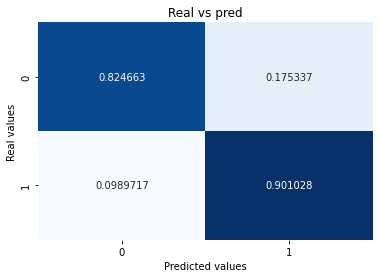

In [ ]:
# Plotting the Confusion matrix
display_cm(y_test, y_pred)

In [65]:
df_rest = pd.read_csv("train.tsv", sep="\t", header=None, names=["sentimiento", "texto"])

#display DataFrame
print(df_rest)

      sentimiento                                              texto
0               1                         nos sentimos muy a gusto .
1               1  buen servicio , ambiente acogedor y tranquilo ...
2               1                                   muy recomendable
3               1  la atencion es muy buena , los camareros estan...
4               1  y la comida espectacular , por eso lo bueno se...
...           ...                                                ...
1858            0  al final pedimos un entrecot y estaba seco y e...
1859            0                                    no volveremos .
1860            1  todo fue perfecto , tanto la atencin del perso...
1861            1                                    lo recomiendo .
1862            1  no puedo disfrutar ms en maur ! la calidad de ...

[1863 rows x 2 columns]


In [66]:
df_rest['sentimiento'].value_counts()

1    1511
0     352
Name: sentimiento, dtype: int64

In [ ]:
df_rest['prediction'] = df_rest['texto'].apply(pred_rnn)

In [ ]:
df_rest.head()

,sentimiento,texto,prediction
0,1,nos sentimos muy a gusto .,Positive
1,1,"buen servicio , ambiente acogedor y tranquilo ...",Positive
2,1,muy recomendable,Positive
3,1,"la atencion es muy buena , los camareros estan...",Positive
4,1,"y la comida espectacular , por eso lo bueno se...",Positive


In [ ]:
df_rest['prediction'].value_counts()

Positive    1105
Negative     758
Name: prediction, dtype: int64

In [ ]:
df_rest.head()

,sentimiento,texto,prediction
0,1,nos sentimos muy a gusto .,Positive
1,1,"buen servicio , ambiente acogedor y tranquilo ...",Positive
2,1,muy recomendable,Positive
3,1,"la atencion es muy buena , los camareros estan...",Positive
4,1,"y la comida espectacular , por eso lo bueno se...",Positive


### Predicting with LR 2

In [ ]:
df_rest['pred_LR'] = df_rest['texto'].apply(pred_tweet)

In [ ]:
df_rest['pred_LR'].value_counts()

Positivo    975
Negativo    888
Name: pred_LR, dtype: int64

In [ ]:
df_comp = df_rest.loc[[df_rest['pred_LR']=='Negativo'] and df_rest['sentimiento']==1]

In [ ]:
df_comp.sample(10)

,sentimiento,texto,prediction,pred_LR
11,1,9reinas ya sido una de las mejores experiencia...,Negative,Positivo
1031,1,"jajajaja , me ro yo de los tenedores .",Negative,Positivo
1389,1,"por lo demas todo perfecto , lo recomiendo y l...",Positive,Positivo
641,1,"le doy un 8,5",Negative,Negativo
732,1,"cocina , platos y sobre todo el personal extra...",Positive,Positivo
780,1,buena calidad y correcta cantidad .,Negative,Positivo
1700,1,buena calidad precio,Positive,Positivo
50,1,el servicio inmejorable y la comida excepciona...,Positive,Positivo
1781,1,"la cena estaba buenisima , es un men muy , muy...",Positive,Positivo
397,1,la pena era que fuimos a cenar y todava no era...,Negative,Negativo


### Probamos algunos modelos Pre-entrenados

In [64]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 13.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 12.8 MB/s eta 0:00:00


In [67]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# Function to predict Sentiment
def sentiment_task(text):
  #text = preprocess(text)
  text = transform_text(text)
  encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  # Print labels and scores
  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  
  for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    #print(f"{i+1}) {l} {np.round(float(s), 4)}")

  pred = config.id2label[ranking[0]]
  intensidad = np.round(float(scores[ranking[0]]), 4)*100
  results = [pred, intensidad]
  return results[0]

In [ ]:
df_rest['pred_roberta'] = df_rest['texto'].apply(sentiment_task)

In [ ]:
df_rest.head()

,sentimiento,texto,prediction,pred_LR,pred_roberta
0,1,nos sentimos muy a gusto .,Positive,Negativo,Positive
1,1,"buen servicio , ambiente acogedor y tranquilo ...",Positive,Positivo,Positive
2,1,muy recomendable,Positive,Positivo,Positive
3,1,"la atencion es muy buena , los camareros estan...",Positive,Positivo,Neutral
4,1,"y la comida espectacular , por eso lo bueno se...",Positive,Positivo,Positive


In [ ]:
df_rest.pred_roberta.value_counts()

Positive    837
Neutral     652
Negative    374
Name: pred_roberta, dtype: int64

In [ ]:
df_spark = spark.createDataFrame(df_rest)

In [ ]:
df_spark.show()

+-----------+--------------------+----------+--------+------------+
|sentimiento|               texto|prediction| pred_LR|pred_roberta|
+-----------+--------------------+----------+--------+------------+
|          1|nos sentimos muy ...|  Positive|Negativo|    Positive|
|          1|buen servicio , a...|  Positive|Positivo|    Positive|
|          1|    muy recomendable|  Positive|Positivo|    Positive|
|          1|la atencion es mu...|  Positive|Positivo|     Neutral|
|          1|y la comida espec...|  Positive|Positivo|    Positive|
|          1|lo unico que vi f...|  Negative|Positivo|    Negative|
|          1|     nada especial .|  Positive|Positivo|     Neutral|
|          1|me haban comentad...|  Positive|Positivo|    Positive|
|          1|las carnes bien ,...|  Positive|Positivo|    Positive|
|          0|el precio , por l...|  Positive|Negativo|    Negative|
|          1|la calidad del pr...|  Positive|Positivo|    Positive|
|          1|9reinas ya sido u...|  Negative|Pos

In [ ]:
# Create a confusion matrix
df_spark.groupBy('sentimiento', 'prediction').count().show()

+-----------+----------+-----+
|sentimiento|prediction|count|
+-----------+----------+-----+
|          1|  Negative|  530|
|          0|  Negative|  228|
|          1|  Positive|  981|
|          0|  Positive|  124|
+-----------+----------+-----+



### Pre-trained Multi-language Sentiment model

In [68]:
from transformers import pipeline

In [69]:
multilang_classifier = pipeline("sentiment-analysis", 
                                model="nlptown/bert-base-multilingual-uncased-sentiment")

In [74]:
multilang_classifier(['¡Enhorabuena! Trabajazo de @susanasolisp como negociadora del @Europarl_ES de los fondos estructurales. Explicación en el hilo.'])

[{'label': '1 star', 'score': 0.3939984440803528}]

### TextBlob and Vader

In [71]:
# Install Libraries
!pip install textblob
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=6feac4e7c18c61db1517d4a305c5c2ad4fedd14bdb0dbd8cb5057964cb9cced3
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [72]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweets:
  #print(tweet.text)
  tweet_list.append(tweet.text)
  analysis = TextBlob(tweet.text)
  score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
  neg = score[‘neg’]
  neu = score[‘neu’]
  pos = score[‘pos’]
  comp = score[‘compound’]
  polarity += analysis.sentiment.polarity
 
  if neg > pos:
    negative_list.append(tweet.text)
    negative += 1
  elif pos > neg:
    positive_list.append(tweet.text)
    positive += 1
 
  elif pos == neg:
    neutral_list.append(tweet.text)
    neutral += 1

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, ‘.1f’)
negative = format(negative, ‘.1f’)
neutral = format(neutral, ‘.1f’)

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[[‘polarity’, ‘subjectivity’]] = tw_list[‘text’].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list[‘text’].iteritems():
 score = SentimentIntensityAnalyzer().polarity_scores(row)
 neg = score[‘neg’]
 neu = score[‘neu’]
 pos = score[‘pos’]
 comp = score[‘compound’]
 if neg > pos:
 tw_list.loc[index, ‘sentiment’] = “negative”
 elif pos > neg:
 tw_list.loc[index, ‘sentiment’] = “positive”
 else:
 tw_list.loc[index, ‘sentiment’] = “neutral”
 tw_list.loc[index, ‘neg’] = neg
 tw_list.loc[index, ‘neu’] = neu
 tw_list.loc[index, ‘pos’] = pos
 tw_list.loc[index, ‘compound’] = comp
tw_list.head(10)

### Recall and Accuracy RNN model

In [ ]:
# Calculate the elements of the confusion matrix
TN = df_spark.filter('prediction = "Negative" AND sentimiento = 0').count()
TP = df_spark.filter('prediction = "Positive" AND sentimiento = 1').count()
FN = df_spark.filter('prediction = "Negative" AND sentimiento = 1').count()
FP = df_spark.filter('prediction = "Positive" AND sentimiento = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN+TP)/(TN+TP+FN+FP)
# Calculate precision and recall
# precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('recall    = {:.2f}\naccuracy    = {:.2f}'.format(recall, accuracy))


recall    = 0.65
accuracy    = 0.65


### Recall and Accuracy LR-2 model

In [ ]:
# Create a confusion matrix
df_spark.groupBy('sentimiento', 'pred_LR').count().show()

+-----------+--------+-----+
|sentimiento| pred_LR|count|
+-----------+--------+-----+
|          0|Positivo|   81|
|          1|Positivo|  894|
|          1|Negativo|  617|
|          0|Negativo|  271|
+-----------+--------+-----+



In [ ]:
# Calculate the elements of the confusion matrix
TN = df_spark.filter('pred_LR = "Negativo" AND sentimiento = 0').count()
TP = df_spark.filter('pred_LR = "Positivo" AND sentimiento = 1').count()
FN = df_spark.filter('pred_LR = "Negativo" AND sentimiento = 1').count()
FP = df_spark.filter('pred_LR = "Positivo" AND sentimiento = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN+TP)/(TN+TP+FN+FP)
# Calculate precision and recall
# precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('recall    = {:.2f}\naccuracy    = {:.2f}'.format(recall, accuracy))

recall    = 0.59
accuracy    = 0.63


### Recall and Accuracy RoBERTa model

In [ ]:
df_spark.groupBy('sentimiento', 'pred_roberta').count().show()

+-----------+------------+-----+
|sentimiento|pred_roberta|count|
+-----------+------------+-----+
|          1|     Neutral|  504|
|          1|    Negative|  206|
|          0|    Negative|  168|
|          1|    Positive|  801|
|          0|    Positive|   36|
|          0|     Neutral|  148|
+-----------+------------+-----+



In [ ]:
# Calculate the elements of the confusion matrix
TN = df_spark.filter('pred_roberta = "Negative" AND sentimiento = 0').count()
TP = df_spark.filter('pred_roberta = "Positive" AND sentimiento = 1').count()
FN = df_spark.filter('pred_roberta = "Negative" AND sentimiento = 1').count()
FP = df_spark.filter('pred_roberta = "Positive" AND sentimiento = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN+TP)/(TN+TP+FN+FP)
# Calculate precision and recall
# precision = TP/(TP+FP)
recall = TP/(TP+FN)
print('recall    = {:.2f}\naccuracy    = {:.2f}'.format(recall, accuracy))

recall    = 0.80
accuracy    = 0.80


In [ ]:
#df_rest.to_csv('Prediccion_Sentimientos_RNN_LR_RoBERTa.csv')

#### 1. Modelo Pysentimiento (BERT based) - A Transformer-based library for SocialNLP classification tasks

**Spanish models**

Usamos pysentimiento una librería basada en transformers y en modelos BERT pre-entrenados como son:

* beto-sentiment-analysis
* beto-emotion-analysis

Ref: https://github.com/pysentimiento/pysentimiento

TASS Dataset license (License for Sentiment Analysis in Spanish, Emotion Analysis in Spanish & English)
http://tass.sepln.org/tass_data/download.php

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 6.6 MB 61.3 MB/s 


### Ejemplos de Pysentimiento

### 2. Sentiment-spanish (CNN based model)

Trained using over 800000 reviews of users of the pages eltenedor, decathlon, tripadvisor, filmaffinity and ebay. 

It uses the libraries Keras and Tensorflow.

Ref: https://pypi.org/project/sentiment-analysis-spanish/

The function sentiment(text) returns a number between 0 and 1. This is the probability of string variable text of being "positive". Low probabilities mean that the text is negative (numbers close to 0), high probabilities (numbers close to 1) mean that the text is positive. The space in between corespond to neutral texts.

### 3. Pretrained Spark-NLP spanish model classifierdl_bert_sentiment

/content/Confusion_Matrix.jpg

### Plotting Charts

#### Plotting Wordcloud

In [ ]:
df_tweets.head()

,sentiment,text,tweets_transform
0,NEUTRAL,"Si salimos vivos entre septiembre y octubre, e...",Si salimos vivos septiembre octubre Liverpool...
1,NEUTRAL,"? Hoy es el cumplea�os de @stevemacca11, scous...",Hoy cumplea scouser marc 50 goles camiseta R...
2,NEUTRAL,En Vivo | �Final del partido! #ManchesterCity ...,Vivo Final partido ManchesterCity venci 20 Che...
3,NEUTRAL,#ManchesterUnited derrot� por 2-1 a #Watford. ...,ManchesterUnited derrot 21 Watford Alexis S n...
4,NEUTRAL,Visto #Wolverhampton vs #Everton (2-2). Me esp...,Visto Wolverhampton vs Everton 22 esperaba ...


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    wd_list = = [w for w in stripped if  w.lower() not in stopWords] # Remover stopwords
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
    


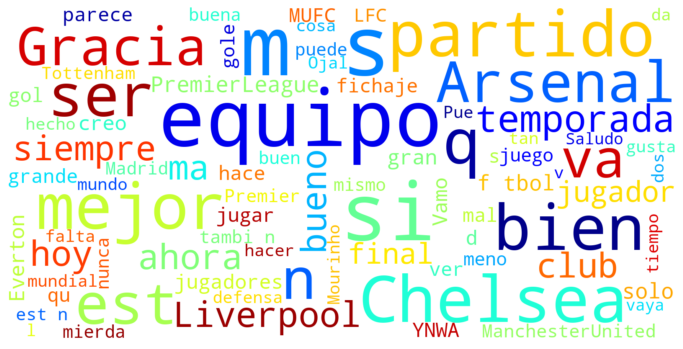

In [ ]:
word_cloud(df_tweets['tweets_transform'])

### Training and evaluating Pre-trained BERT-BASED Models

Evaluate the results of training